# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [ ]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

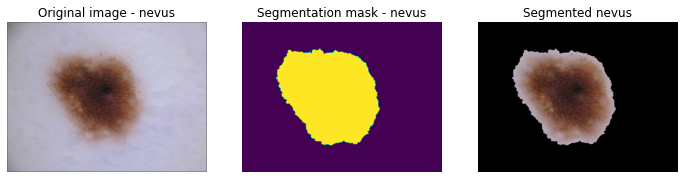

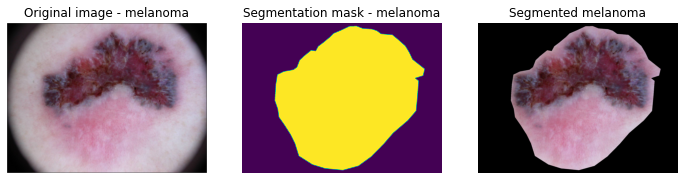

In [ ]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [ ]:
X.shape

(600, 30)

In [ ]:
y.shape

(600,)

In [ ]:
# Shuffle data randomly
np.random.seed(0)
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
Xp=X[idx]
yp=y[idx]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

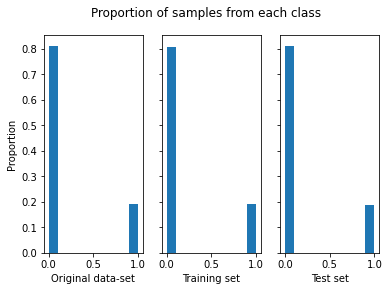

In [ ]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

**Question:** As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ?

**Answer:** When using a training and test set we should compute the standardization parameters (mean and variance) using only the training set and then trasform both the training and test sets using the parameters learnt only on the training set. This is because the test set is used to assess the performance of the model on unseen data, simulating a "real-life" scenario, where we wouldn't recompute the standardization parameters.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit( X_train ) 
X_train_scale = scaler.transform( X_train )
X_test_scale = scaler.transform( X_test )

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

**Answer:** We see that both algorithms had a similar performance and that the most commom mistake they make is classifying a melanoma as a healthy lesion. In fact, overall, the models priviledge classifying a lesion as healthy, which might be due to the unbalancing between the classes.

Fitting LDA to scaled training set
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.65      0.38      0.48        34

    accuracy                           0.84       180
   macro avg       0.76      0.67      0.69       180
weighted avg       0.83      0.84      0.83       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.61764706 0.38235294]]


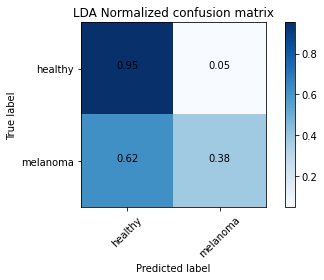

Fitting QDA to scaled training set
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.65      0.38      0.48        34

    accuracy                           0.84       180
   macro avg       0.76      0.67      0.69       180
weighted avg       0.83      0.84      0.83       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.61764706 0.38235294]]


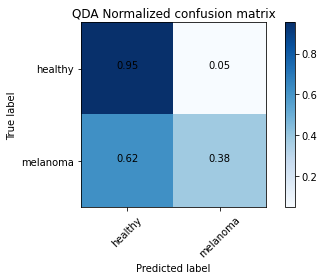

In [ ]:
# Fitting LDA
print("Fitting LDA to scaled training set")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to scaled training set")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

**Question:** The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

**Answer:** In order to have a generalization error that is less dependent on the chosen subdivision of the dataset we could use cross-validation.

In [ ]:
from sklearn.pipeline import make_pipeline

# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=Xp, y=np.ravel(yp),cv=5)
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=Xp, y=np.ravel(yp),cv=5)
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting K-nearest neighbour
print("Fitting KNN (K=3)")
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=Xp, y=np.ravel(yp),cv=5)
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
 Average and std CV score : 0.82 +- 0.036742346141747664
Fitting QDA
 Average and std CV score : 0.7949999999999999 +- 0.0335824027993498
Fitting KNN (K=3)
 Average and std CV score : 0.7866666666666667 +- 0.02867441755680878


**Question:** When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

**Answer:** When plotting the confusion matrix we notice that the model almost always classifies the skin lesion as healthy, which I believe is due to the unbalancing of the classes. We have many more samples of healthy lesions then melanomas, therefore the model can always classify a sample as healthy and still have a good performance as measured by the accuracy metric.

Best training Score: 0.8047619047619048
Best training params: {'n_neighbors': 6}
Normalized confusion matrix
[[0.99315068 0.00684932]
 [0.97058824 0.02941176]]


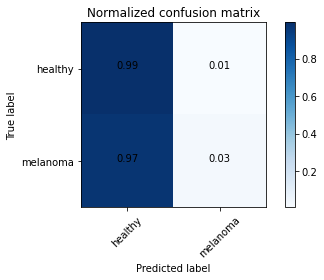

In [ ]:
# I used this cell as it was given, i.e., without scaling the data, therefore, 
# for consistency, in the cells imediately bellow, concerning KNN, I kept
# on using non-scaled data

# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

**Answer:** A more appropriate scoring function for an imbalanced dataset would be balanced accuracy, which is the average of the recall obtained on each class.

Best training Score: 0.5343393327480246
Best training params: {'n_neighbors': 3}
Normalized confusion matrix
[[0.89041096 0.10958904]
 [0.82352941 0.17647059]]


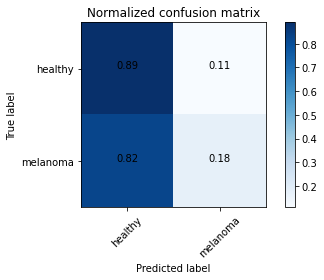

In [ ]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and try at least one naive random over-sampling (look at the following code...).

**Answer:** We should oversample the melanoma class.

In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 333)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

**Answer:** Yes, the results are better when compared to when we used the accuracy as the score on an imbalanced dataset, now the data distribution doesn't priviledge healthy samples anymore. Also the results do not change when we change the scoring function to balanced accuracy, because since the classes are balanced, taking the standard accuracy or the average of the accuracy on each class will be equivalent.

Best training Score: 0.8362962962962964
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.69863014 0.30136986]
 [0.61764706 0.38235294]]


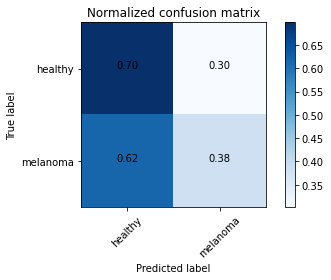

In [ ]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Best training Score: 0.837530928246468
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.69863014 0.30136986]
 [0.61764706 0.38235294]]


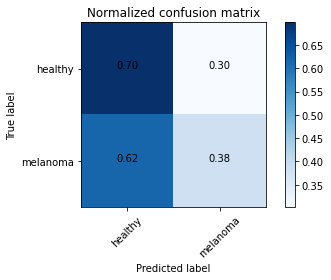

In [ ]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="balanced_accuracy", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use the techniques seen today: Perceptron and linear SVM. 

In [ ]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7470833333333334 +- 0.0776231101040291
 Average and std TEST CV accuracy : 0.7333333333333334 +- 0.0560257877132387
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8445833333333332 +- 0.008186201126828514
 Average and std TEST CV accuracy : 0.8150000000000001 +- 0.027588242262078077


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [ ]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7470833333333334 +- 0.0776231101040291
 Average and std TEST CV accuracy : 0.7333333333333334 +- 0.0560257877132387
 Average and std TRAIN CV f1 : 0.3537323169112906 +- 0.09920379279242054
 Average and std TEST CV f1 : 0.31268115942028984 +- 0.13015303261005437
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8445833333333332 +- 0.009185586535436885
 Average and std TEST CV accuracy : 0.8166666666666667 +- 0.030276503540974907
 Average and std TRAIN CV f1 : 0.4232648148148147 +- 0.054530308834799875
 Average and std TEST CV f1 : 0.3179002891479172 +- 0.12405616130539299


**Question** Please do the same on the oversampled data and compare the results with the previous ones.

**Answer:** Comparing the results for oversampled data with the previous ones we see an improvement on the f1 score but a reduction of accuracy. In order to analyse the results we must consider each of these scoring functions.

Accuracy is defined as the fraction of correct predictions. F1 score is a weighted harmonic mean of precision and recall:
$$precision = \frac{tp}{tp+fp}$$
$$recall = \frac{tp}{tp+fn}$$
And in this case the positive labels are associated to melanoma.

So when we have an imbalanced dataset, the model can easily reach a high accuracy by priviledging the classification of samples as healthy, like what happened when finding the best $K$ for KNN. When we balance the dataset, this isn't possible anymore, so we see a degradation of accuracy. On the other hand, the F1 score is measuring how well the model classifies melanoma samples, therefore it is improved when we balance the dataset, which amounts to giving the same importance to both melanoma and healthy samples.

In [ ]:
from imblearn.pipeline import make_pipeline as make_pipeline2 

# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0), StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Lsvm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6779166666666667 +- 0.06692138837637952
 Average and std TEST CV accuracy : 0.64 +- 0.08698658900466592
 Average and std TRAIN CV f1 : 0.43482291727742783 +- 0.06267577882127977
 Average and std TEST CV f1 : 0.38198105751006467 +- 0.056281050480672
Fitting Linear SVM
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.75875 +- 0.013527235900623257
 Average and std TEST CV accuracy : 0.6966666666666667 +- 0.05286250509051238
 Average and std TRAIN CV f1 : 0.5236461400119602 +- 0.03078861685972652
 Average and std TEST CV f1 : 0.41094336951343396 +- 0.06959177397845218


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.669047619047619 +- 0.07574740964565858
 Average and std TEST CV accuracy : 0.6309523809523809 +- 0.1070105002583059
 Average and std TRAIN CV f1 : 0.42636885624902376 +- 0.053095244119873576
 Average and std TEST CV f1 : 0.34571379428964566 +- 0.07875949805782699
Normalized confusion matrix
[[0.79452055 0.20547945]
 [0.38235294 0.61764706]]


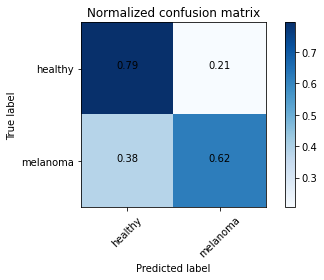

In [ ]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Fitting SVM
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7553571428571428 +- 0.01426089113179873
 Average and std TEST CV accuracy : 0.6880952380952381 +- 0.0138832187972507
 Average and std TRAIN CV f1 : 0.5215364727124449 +- 0.027488520982421123
 Average and std TEST CV f1 : 0.3907337699169804 +- 0.02095594146507193
Normalized confusion matrix
[[0.76712329 0.23287671]
 [0.32352941 0.67647059]]


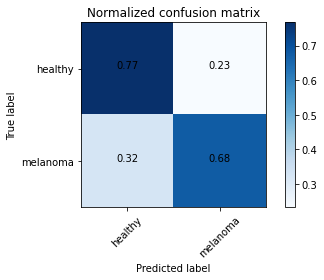

In [ ]:
# Fitting linear SVM 
print("Fitting SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Lsvm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best = Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

**Answer:** The best C value was $0.001$.

Best training Score: 0.7142857142857143
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


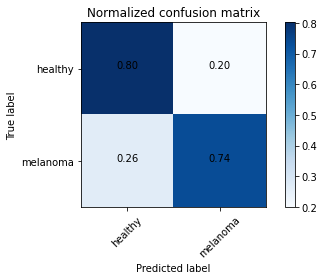

In [ ]:
# Looking for the best hyperparameter C 
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring='accuracy', cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $\gamma$ value. Plot the confusion matrix using the best estimator (as before).

**Answer:** The best values for $C$ and $\gamma$ were, respectively, 0.1 and 0.1.

Fitting Non-linear SVM to the training set
Best training Score: 0.8142857142857143
Best training params: {'svc__C': 0.1, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.82352941 0.17647059]]


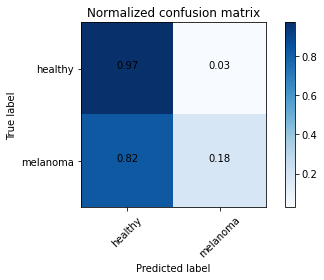

In [ ]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf')) 
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring='accuracy', cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Answer:** In the previous cell, non-linear SVM was already applied to oversampled data, therefore we will test it with a different scoring function, the f1 score. We see that the results change, which is due to the fact that those two metrics, accuracy and f1-score, are evaluating different things: accuracy only measures the fraction of correctly identified cases; while f1-score takes into account precision and recall.

Fitting Non-linear SVM to the training set
Best training Score: 0.5061294675895694
Best training params: {'svc__C': 7, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.84931507 0.15068493]
 [0.41176471 0.58823529]]


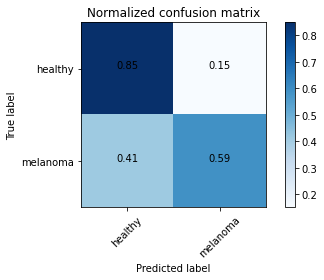

In [ ]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf')) 
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring='f1', cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer:** 

In order to determine which is the best method, we need to consider the context of the experiment: we are trying to detect melanoma since the most effective treatment for this type of cancer is an early detection followed by surgical excision. Therefore, in this case, false negatives must be avoided, because the patient will believe he is safe and the cancer will grow; on the other hand, false positives aren't as bad, because then the patient will see a doctor who will hopefully conclude that in fact he does not have melanoma. Therefore, from this point of view, the best method is the linear SVM method with $C=0.001$ and an adequate scoring function would be the f1 score.

Furthermore, it is important to oversample the melanoma class since the original dataset was strongly imbalanced, with melanoma corresponding to only $20\%$ of the samples. This unbalance causes the methods to favor the healthy class when using a scoring function that is not adapted to an imbalanced dataset, such as accuracy.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [ ]:
# # Test PCA with a linear SVM
# XXXXXXXX

In [ ]:
# # Fitting Linear SVM 
# XXXXXXXXXX

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [ ]:
# # Implement forward feature selection and/or backward feature selection
# # with a linear SVM

# XXXXXXXXXX